# Breakout: Individual Project Code

## Google Drive Integration

Mount Google Drive.

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

## Setup

Import modules.

In [3]:
import gym
import numpy as np
import random
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
import cv2

Set device.

In [4]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('device: ', device)

device:  cpu


Set environment.

In [5]:
env = gym.make('Breakout-v0')

Set seed for reproducible environment and action spaces

In [6]:
seed = 742
torch.manual_seed(seed)
env.seed(seed)
random.seed(seed)
np.random.seed(seed)
env.action_space.seed(seed)

[742]

## Environment preview

In [7]:
def show_image(image, greyscale=False):
    """Displays image without grid lines."""
    if greyscale:
        plt.imshow(image, cmap=plt.get_cmap('gray'))    
    else:
        plt.imshow(image)
    plt.xticks([])
    plt.yticks([])

Show the initial state and print its shape.

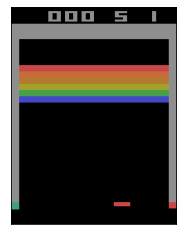

obervation space:  Box(210, 160, 3)
action space:  Discrete(4)
no. actions:  4


In [8]:
observation = env.reset()

show_image(observation)
plt.show()

print('obervation space: ', env.observation_space)
print('action space: ', env.action_space)
print('no. actions: ', env.action_space.n)

Take a random action, then make an observation.

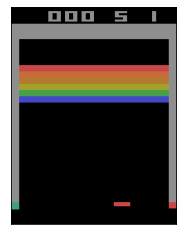

action: 0
reward: 0.0
done False
info {'ale.lives': 5}


In [9]:
random_action = env.action_space.sample()

next_observation, reward, done, info = env.step(random_action)

show_image(next_observation)
plt.show()

print('action:', random_action)
print('reward:', reward)
print('done', done)
print('info', info)

## Frame pre-processing

In [10]:
obs = env.reset()

### Greyscale

shape before:  (210, 160, 3)
shape after:   (210, 160)


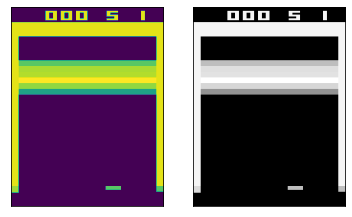

In [11]:
print("shape before: ", obs.shape)
gray_obs = cv2.cvtColor(obs, cv2.COLOR_RGB2GRAY)
print("shape after:  ", gray_obs.shape)

plt.subplot(1, 2, 1)
show_image(gray_obs)
plt.subplot(1, 2, 2)
show_image(gray_obs, greyscale=True)
plt.show()

### Crop

shape before:  (210, 160)
shape after:   (160, 160)


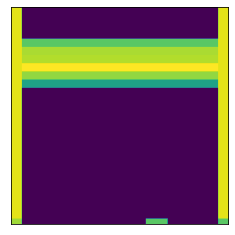

In [12]:
print('shape before: ', gray_obs.shape)
cropped_obs = gray_obs[33:193]
print('shape after:  ', cropped_obs.shape)

show_image(cropped_obs)

### Resize

shape before:  (160, 160)
shape after transformation:   (84, 84)


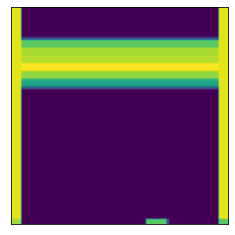

In [13]:
print("shape before: ", cropped_obs.shape)
resized_obs = cv2.resize(cropped_obs, (84, 84))
print("shape after transformation:  ", resized_obs.shape)

show_image(resized_obs)

### Pre-processing function

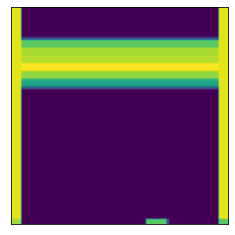

In [14]:
def preprocess(obs):
  gray_obs = cv2.cvtColor(obs, cv2.COLOR_RGB2GRAY)
  cropped_obs = gray_obs[33:193]
  resized_obs = cv2.resize(cropped_obs, (84, 84))
  return resized_obs

show_image(preprocess(env.reset()))

View pre-processed next state, having taken a random action. 

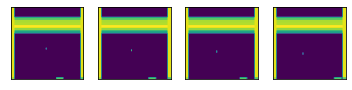

In [15]:
for i in range(4):
    rand_act = env.action_space.sample()
    obs = env.step(rand_act)[0]
    
    plt.subplot(1, 4, i+1)
    show_image(preprocess(obs))
plt.show()

## State

In [16]:
def show_state(state):
    for i, frame in enumerate(state):
        plt.subplot(1, len(state), i+1)
        plt.imshow(frame, cmap=plt.get_cmap('gray'))
        plt.xticks([])
        plt.yticks([])

### Let state be 4 consecutive frames.

In [17]:
state = torch.zeros(4, 84, 84)

current state:


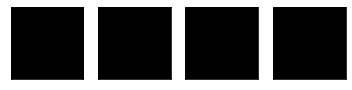

next state:


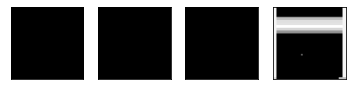

In [18]:
print('current state:')
show_state(state)
plt.show()

action = env.action_space.sample()
next_obs = preprocess(env.step(action)[0])

state = torch.roll(state, shifts=-1, dims=0)
state[-1] = torch.tensor(next_obs).unsqueeze(0)

print('next state:')
show_state(state)
plt.show()

## Model definition

### Define CNN layer.

In [19]:
cnn = nn.Sequential(
    nn.Conv2d(in_channels=4, out_channels=32, kernel_size=8, stride=4),
    nn.ReLU(),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2),
    nn.ReLU(),
    nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1),
    nn.ReLU()
    )

cnn.to(device)

Sequential(
  (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
  (1): ReLU()
  (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
  (3): ReLU()
  (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (5): ReLU()
)

Feed state buffer stack through CNN layer.

In [20]:
cnn_out = cnn(state.unsqueeze(0))
print('shape of CNN output: ', cnn_out.shape)

shape of CNN output:  torch.Size([1, 64, 7, 7])


Flatten CNN layer output, and print.

In [21]:
fc_input_dim = cnn_out.flatten().shape[0]
print('fully connecetd layer input size: ', fc_input_dim)

fully connecetd layer input size:  3136


### Define fully-connected (fc) policy layer.

In [22]:
fc_pi = nn.Sequential(
    nn.Linear(fc_input_dim, 512),
    nn.ReLU(),
    nn.Linear(512, env.action_space.n)
    )

fc_pi.to(device)

Sequential(
  (0): Linear(in_features=3136, out_features=512, bias=True)
  (1): ReLU()
  (2): Linear(in_features=512, out_features=4, bias=True)
)

Reshape CNN layer output, then feed through fc layer.

In [23]:
shape_before = cnn_out.shape
print('shape before reshape: ', shape_before)
fc_input = cnn_out.reshape(-1, fc_input_dim)
print('shape after reshape:  ', fc_input.shape)

shape before reshape:  torch.Size([1, 64, 7, 7])
shape after reshape:   torch.Size([1, 3136])


View fc policy layer output.

In [24]:
fc_output = fc_pi(fc_input)
fc_output

tensor([[-0.1238, -0.1484,  0.3725,  0.0406]], grad_fn=<AddmmBackward>)

View fc layer output shape to obtain softmax dimension.

In [25]:
print(fc_output.shape)

torch.Size([1, 4])


We want the sum of action probabilities to equal 1. The porbabilities come from the values on the last axis (axis 1).

In [26]:
softmax_dim = 1

Obtain action probabilities from values.

In [27]:
prob = F.softmax(fc_output, dim=softmax_dim)
prob

tensor([[0.2085, 0.2034, 0.3424, 0.2457]], grad_fn=<SoftmaxBackward>)

Turn action probabilities into a categorical distribution.

> 'A categorical distribution is a discrete probability distribution that describes the possible results of a random variable that can take on one of K possible categories, with the probability of each category separately specified' &mdash; Wikipedia

In [28]:
m = Categorical(prob)
m

Categorical(probs: torch.Size([1, 4]))

Sample an action from the categorical distribution.

In [29]:
a = m.sample().item() # .item() converts it from tensor to int
a

0

### Define fully connected (fc) value layer.

In [30]:
fc_v = nn.Sequential(
    nn.Linear(fc_input_dim, 512),
    nn.ReLU(),
    nn.Linear(512, 1)
    )

fc_v.to(device)

Sequential(
  (0): Linear(in_features=3136, out_features=512, bias=True)
  (1): ReLU()
  (2): Linear(in_features=512, out_features=1, bias=True)
)

View fc value layer output.

In [31]:
fc_out = fc_v(fc_input)
fc_out

tensor([[0.4275]], grad_fn=<AddmmBackward>)

### Define functions

Define a function to pass a state buffer stack through the network and obtain action probabilities.

In [31]:
def pi(x):
  x_t = x.to(device)
  cnn_out = cnn(x_t)
  fc_in = cnn_out.reshape(-1, fc_input_dim)
  fc_out = fc_pi(fc_in)
  prob = F.softmax(fc_out, dim=softmax_dim)
  return prob

Check `pi` output.

In [32]:
pi(state.unsqueeze(0))

tensor([[0.2085, 0.2034, 0.3424, 0.2457]], grad_fn=<SoftmaxBackward>)

In [33]:
def v(x):
  x_t = x.to(device)
  cnn_out = cnn(x_t)
  fc_in = cnn_out.reshape(-1, fc_input_dim)
  v = fc_v(fc_in)
  return v

Check `v` output.

In [34]:
v(state.unsqueeze(0))

tensor([[0.4275]], grad_fn=<AddmmBackward>)

## Checks

Get probability as float from tensor.

In [35]:
prob = pi(state.unsqueeze(0))
m = Categorical(prob)
a = m.sample().item()
print(prob)
print('action: ', a)
print('action probability: ', prob.cpu().detach().numpy()[0][a])

tensor([[0.2085, 0.2034, 0.3424, 0.2457]], grad_fn=<SoftmaxBackward>)
action:  2
action probability:  0.34243265


## Proximal Policy Optimisation (PPO)

In [36]:
# hyperparameters
learning_rate = 2.5e-4
gamma         = 0.99
lmbda         = 0.95
eps_clip      = 0.1
K_epoch       = 3

class PPO(nn.Module):
    def __init__(self):
        super(PPO, self).__init__()
        self.data = []
        self.loss_data = []
        
        self.cnn = nn.Sequential(
            nn.Conv2d(in_channels=4, out_channels=32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1),
            nn.ReLU()
            )
        
        self.fc_pi = nn.Sequential(
            nn.Linear(fc_input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, env.action_space.n)
            )
        
        self.fc_v = nn.Sequential(
            nn.Linear(fc_input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 1)
            )
        
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

    def pi(self, x, softmax_dim=1):
        cnn_out = self.cnn(x).reshape(-1, fc_input_dim)
        prob = F.softmax(self.fc_pi(cnn_out), dim=softmax_dim)
        return prob
    
    def v(self, x):
        cnn_out = self.cnn(x).reshape(-1, fc_input_dim)
        v = self.fc_v(cnn_out)
        return v

    def put_data(self, transition):
        self.data.append(transition)
        
    def make_batch(self):
        s_lst, a_lst, r_lst, s_prime_lst, prob_a_lst, done_lst = [], [], [], [], [], []
        for transition in self.data:
            s, a, r, s_prime, prob_a, done = transition
            
            s_lst.append(s)
            a_lst.append([a])
            r_lst.append([r])
            s_prime_lst.append(s_prime)
            prob_a_lst.append([prob_a])
            done_mask = 0 if done else 1
            done_lst.append([done_mask])
            
        s,a,r,s_prime,done_mask, prob_a = torch.tensor(s_lst, dtype=torch.float, device=device), torch.tensor(a_lst, device=device), \
                                          torch.tensor(r_lst, device=device), torch.tensor(s_prime_lst, dtype=torch.float, device=device), \
                                          torch.tensor(done_lst, dtype=torch.float, device=device), torch.tensor(prob_a_lst, device=device)
        self.data = []
        return s, a, r, s_prime, done_mask, prob_a
        
    def train_net(self):
        s, a, r, s_prime, done_mask, prob_a = self.make_batch()

        for i in range(K_epoch):
            td_target = r + gamma * self.v(s_prime) * done_mask
            delta = td_target - self.v(s)
            delta = delta.cpu().detach().numpy()

            advantage_lst = []
            advantage = 0.0
            for delta_t in delta[::-1]:
                advantage = gamma * lmbda * advantage + delta_t[0]
                advantage_lst.append([advantage])
            advantage_lst.reverse()
            advantage = torch.tensor(advantage_lst, dtype=torch.float, device=device)

            pi = self.pi(s, softmax_dim=1)
            pi_a = pi.gather(1,a)
            ratio = torch.exp(torch.log(pi_a) - torch.log(prob_a))  # a/b == exp(log(a)-log(b))

            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1-eps_clip, 1+eps_clip) * advantage
            loss = -torch.min(surr1, surr2) + F.smooth_l1_loss(self.v(s) , td_target.detach())
            # self.loss_data.append(loss.detach().numpy().mean)

            self.optimizer.zero_grad()
            loss.mean().backward()
            self.optimizer.step()


torch.Size([1, 4, 84, 84])
tensor([[0.1856, 0.2152, 0.0428, 0.5564]], grad_fn=<SoftmaxBackward>)


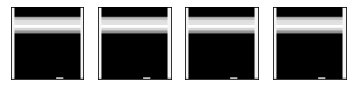

In [37]:
model = PPO()

obs = preprocess(env.reset())
state = np.stack((obs, obs, obs, obs), axis=0)
show_state(state)

pi_in = torch.from_numpy(state).float().unsqueeze(0)
print(pi_in.shape)
prob = model.pi(pi_in)
m = Categorical(prob)
a = m.sample().item()
print(prob)
    

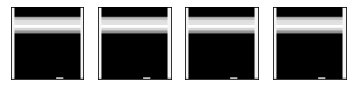

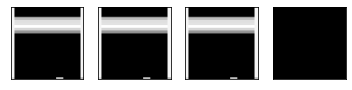

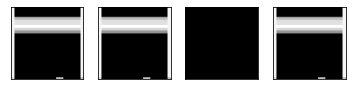

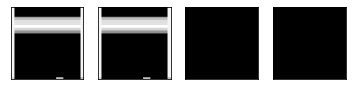

In [38]:
obs = preprocess(env.reset())
state = np.stack((obs, obs, obs, obs), axis=0)
show_state(state)
plt.show()

state[-1] = np.zeros(84)
show_state(state)
plt.show()

state = np.roll(state, shift=-1, axis=0)
show_state(state)
plt.show()

state[-1] = np.zeros(84)
show_state(state)
plt.show()

## Training loop and results

← You can download the videos from the videos folder in the files on the left

In [43]:
from datetime import datetime
import os

env_name = 'Breakout-v0'
dir_name = datetime.now().strftime("%Y-%m-%d_%I-%M-%S-%p") + '_' + env_name
video_dir = dir_name + '/video'

os.mkdir(dir_name)

env = gym.make(env_name)
env = gym.wrappers.Monitor(env, video_dir, video_callable=lambda episode_id: (episode_id%video_every)==0,force=True)

# hyperparameters
T_horizon     = 64
video_every   = 50
print_every   = 5
number_of_games = 1000

figure_file = dir_name + '/figure.png'
scores_file = dir_name + '/scores.txt'

# logs
score_history = []
learn_iters = 0
avg_score = 0
n_steps = 0

model = PPO().to(device)

for n_episode in range(1, number_of_games+1):
    
    obs = preprocess(env.reset())

    state = np.stack((obs, obs, obs, obs), axis=0)
    
    done = False
    score = 0.0
    while not done: 
        for t in range(T_horizon):

            prob = model.pi(torch.from_numpy(state).float().unsqueeze(0))
            m = Categorical(prob)
            a = m.sample().item()

            reward = 0
            for _ in range(4):
                next_obs, r, done, info = env.step(a)
                reward += r

                if done:
                    break

                # if info['ale.lives'] < 5:
                #     done = True
                #     break
            
            next_state = np.roll(state, shift=-1, axis=0)
            next_state[-1] = preprocess(next_obs) 

            model.put_data((state, a, reward, next_state, prob.cpu().detach().numpy()[0][a], done))
            
            state = next_state

            n_steps += 1
            score += reward

            if done:
                # env.stats_recorder.done = True
                break

        model.train_net()
        learn_iters += 1
    
    score_history.append(score)
    # avg_score = np.mean(score_history[-100:])

    # x = range(len(score_history))
    # plt.subplot(1,2,1)
    # plt.plot(x, score)
    # plt.subplot(1,2,2)
    # print(model.loss_data)
    # # plt.plot([0,1,2], )
    # plt.show()

    if n_episode%video_every == 0:
        pth = dir_name + '/' + 'ep=' + str(n_episode) + '_avg=' + '%.2f' % avg_score + '.pth'
        torch.save(model.state_dict(), pth)

    if n_episode%print_every==0 and n_episode!=0:
        print('episode: ', n_episode, 'score %.1f' % score, 'mean_score: %.2f' % np.array(score_history).mean(),
        'std_score: %.2f' % np.array(score_history).std(), 'time_steps', n_steps, 'learning_steps', learn_iters)
        score_history = []

env.close()

episode:  5 score 1.0 mean_score: 2.00 std_score: 0.63 time_steps 473 learning_steps 11
episode:  10 score 2.0 mean_score: 1.20 std_score: 0.75 time_steps 768 learning_steps 16
episode:  15 score 0.0 mean_score: 1.40 std_score: 0.80 time_steps 1160 learning_steps 25
episode:  20 score 2.0 mean_score: 2.60 std_score: 0.80 time_steps 1718 learning_steps 36
episode:  25 score 2.0 mean_score: 2.20 std_score: 1.33 time_steps 2239 learning_steps 47
episode:  30 score 5.0 mean_score: 3.20 std_score: 1.33 time_steps 2801 learning_steps 57
episode:  35 score 1.0 mean_score: 2.40 std_score: 1.50 time_steps 3255 learning_steps 67
episode:  40 score 8.0 mean_score: 4.60 std_score: 1.74 time_steps 3808 learning_steps 78
episode:  45 score 2.0 mean_score: 3.20 std_score: 1.94 time_steps 4263 learning_steps 89
episode:  50 score 1.0 mean_score: 3.20 std_score: 2.14 time_steps 4767 learning_steps 99
episode:  55 score 1.0 mean_score: 2.60 std_score: 1.36 time_steps 5195 learning_steps 107
episode:  60

KeyboardInterrupt: 

In [70]:
model = PPO().to(device)
model.load_state_dict(torch.load(pth))

<All keys matched successfully>

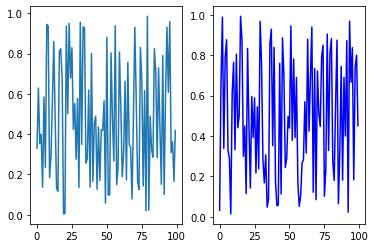

In [69]:
import random

n = 100
x = [i for i in range(n)]
y1 = [random.random() for i in range(n)]
y2 = [random.random() for i in range(n)]
plt.subplot(1,2,1)
plt.plot(range(n), y1)
plt.subplot(1,2,2)
plt.plot(x, y2, 'b')
plt.show()

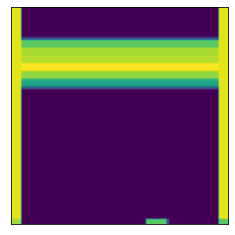

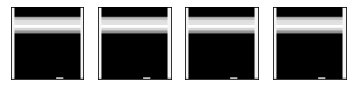

tensor([[0.4372, 0.1176, 0.0404, 0.4048]], grad_fn=<SoftmaxBackward>)
1
0.0


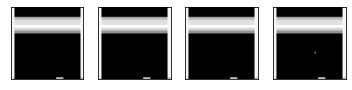

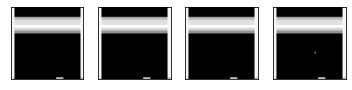

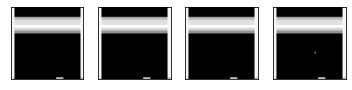

tensor([[0.4400, 0.1156, 0.0398, 0.4045]], grad_fn=<SoftmaxBackward>)
2
0.0


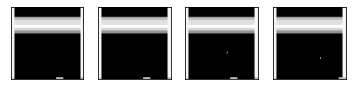

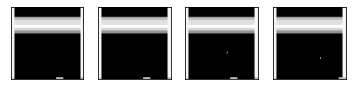

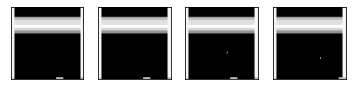

tensor([[0.4397, 0.1143, 0.0398, 0.4062]], grad_fn=<SoftmaxBackward>)
1
0.0


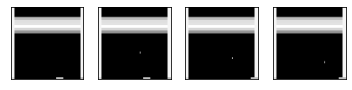

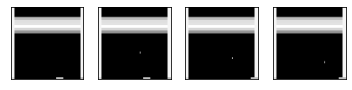

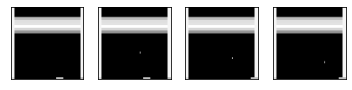

tensor([[0.4412, 0.1148, 0.0399, 0.4042]], grad_fn=<SoftmaxBackward>)
3
0.0


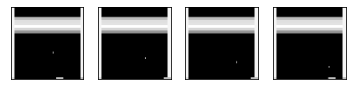

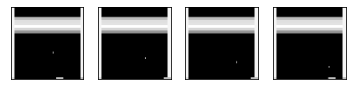

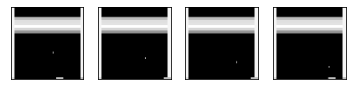

tensor([[0.4322, 0.1143, 0.0384, 0.4151]], grad_fn=<SoftmaxBackward>)
1
0.0


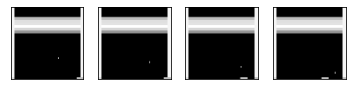

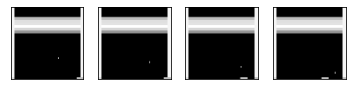

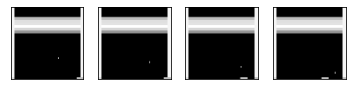

tensor([[0.4165, 0.1135, 0.0391, 0.4309]], grad_fn=<SoftmaxBackward>)
0
0.0


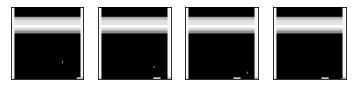

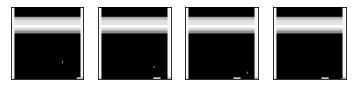

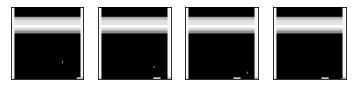

tensor([[0.4277, 0.1118, 0.0380, 0.4225]], grad_fn=<SoftmaxBackward>)
0
0.0


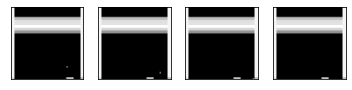

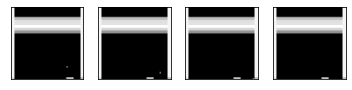

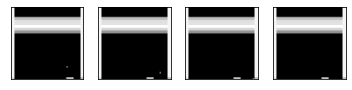

tensor([[0.4209, 0.1184, 0.0390, 0.4216]], grad_fn=<SoftmaxBackward>)
3
0.0


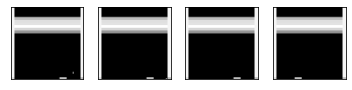

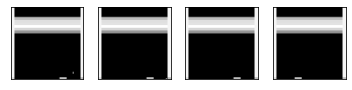

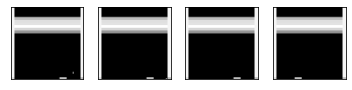

tensor([[0.4388, 0.1157, 0.0362, 0.4093]], grad_fn=<SoftmaxBackward>)
3
0.0


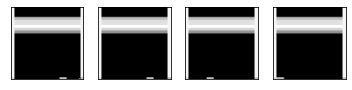

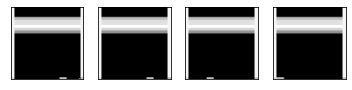

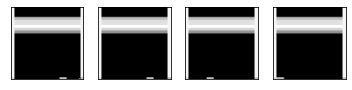

tensor([[0.4390, 0.1160, 0.0368, 0.4082]], grad_fn=<SoftmaxBackward>)
0
0.0


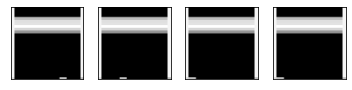

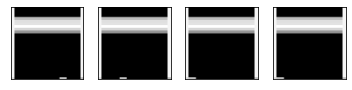

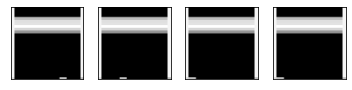

tensor([[0.4341, 0.1098, 0.0381, 0.4180]], grad_fn=<SoftmaxBackward>)
3
0.0


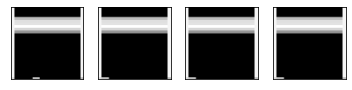

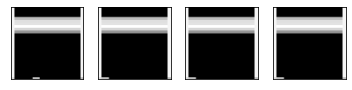

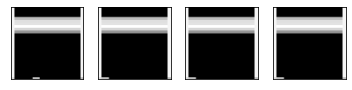

tensor([[0.4466, 0.1139, 0.0370, 0.4024]], grad_fn=<SoftmaxBackward>)
0
0.0


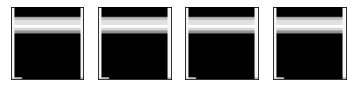

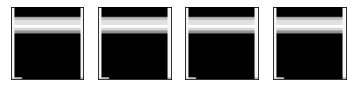

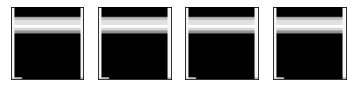

tensor([[0.4368, 0.1124, 0.0386, 0.4122]], grad_fn=<SoftmaxBackward>)
0
0.0


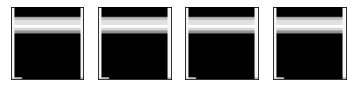

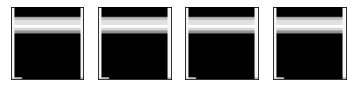

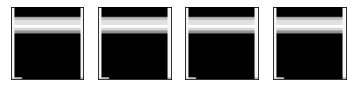

tensor([[0.4368, 0.1124, 0.0386, 0.4122]], grad_fn=<SoftmaxBackward>)
3
0.0


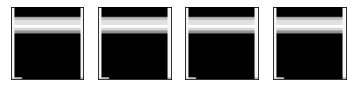

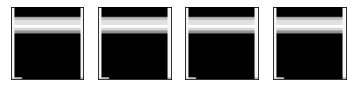

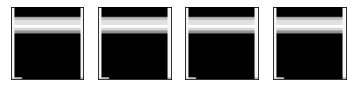

tensor([[0.4368, 0.1124, 0.0386, 0.4122]], grad_fn=<SoftmaxBackward>)
0
0.0


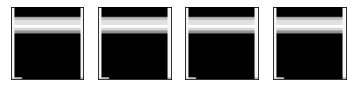

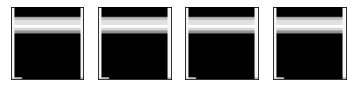

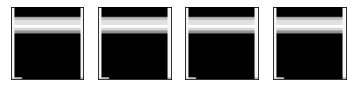

tensor([[0.4368, 0.1124, 0.0386, 0.4122]], grad_fn=<SoftmaxBackward>)
3
0.0


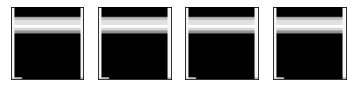

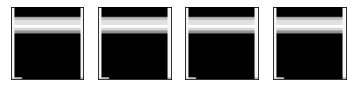

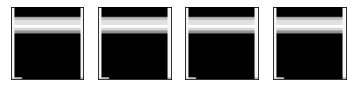

tensor([[0.4368, 0.1124, 0.0386, 0.4122]], grad_fn=<SoftmaxBackward>)
0
0.0


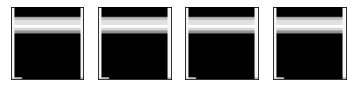

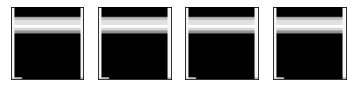

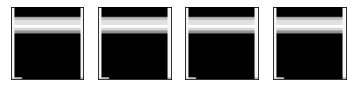

tensor([[0.4368, 0.1124, 0.0386, 0.4122]], grad_fn=<SoftmaxBackward>)
3
0.0


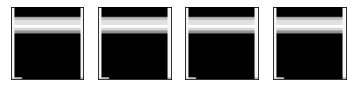

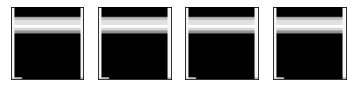

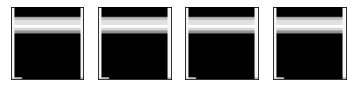

tensor([[0.4368, 0.1124, 0.0386, 0.4122]], grad_fn=<SoftmaxBackward>)
3
0.0


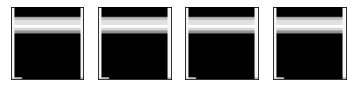

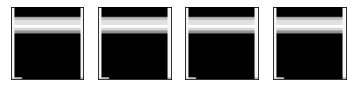

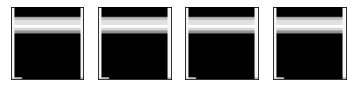

tensor([[0.4368, 0.1124, 0.0386, 0.4122]], grad_fn=<SoftmaxBackward>)
0
0.0


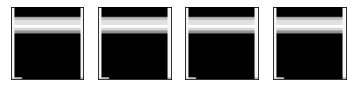

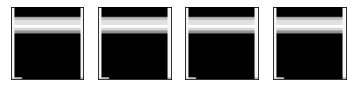

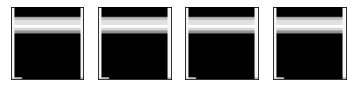

tensor([[0.4368, 0.1124, 0.0386, 0.4122]], grad_fn=<SoftmaxBackward>)
0
0.0


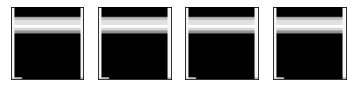

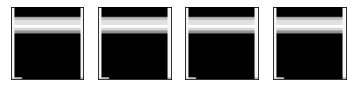

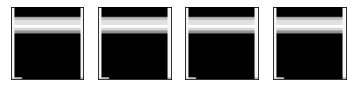

tensor([[0.4368, 0.1124, 0.0386, 0.4122]], grad_fn=<SoftmaxBackward>)
1
0.0


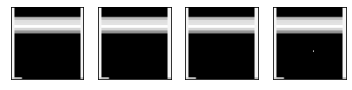

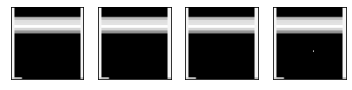

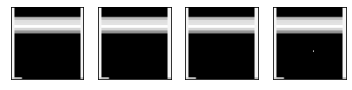

tensor([[0.4369, 0.1060, 0.0382, 0.4189]], grad_fn=<SoftmaxBackward>)
2
0.0


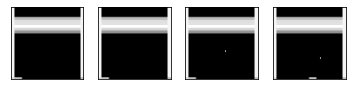

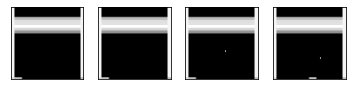

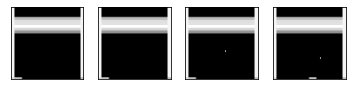

tensor([[0.4654, 0.1016, 0.0392, 0.3938]], grad_fn=<SoftmaxBackward>)
0
0.0


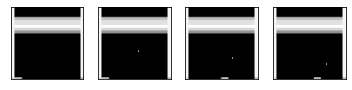

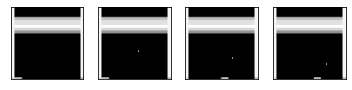

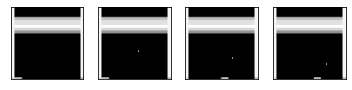

tensor([[0.4474, 0.1107, 0.0407, 0.4012]], grad_fn=<SoftmaxBackward>)
2
0.0


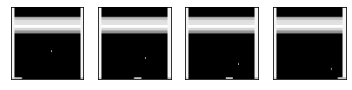

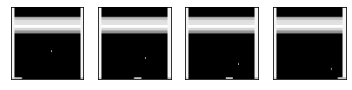

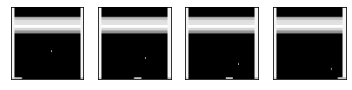

tensor([[0.4631, 0.1052, 0.0424, 0.3892]], grad_fn=<SoftmaxBackward>)
0
0.0


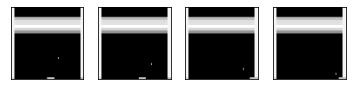

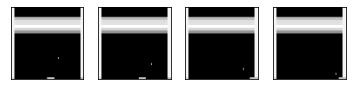

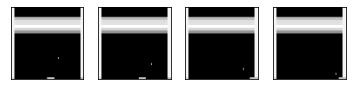

tensor([[0.4397, 0.1150, 0.0389, 0.4064]], grad_fn=<SoftmaxBackward>)
3
0.0


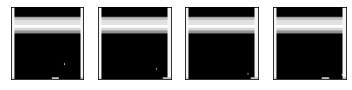

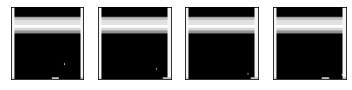

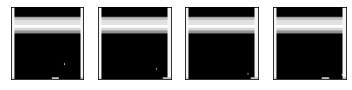

tensor([[0.4264, 0.1235, 0.0408, 0.4093]], grad_fn=<SoftmaxBackward>)
2
0.0


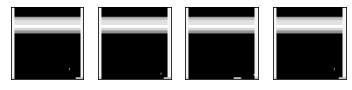

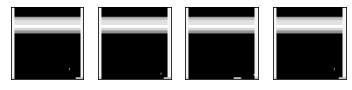

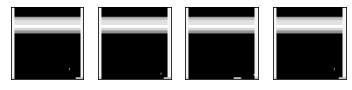

tensor([[0.4181, 0.1172, 0.0387, 0.4260]], grad_fn=<SoftmaxBackward>)
3
0.0


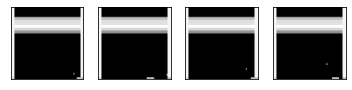

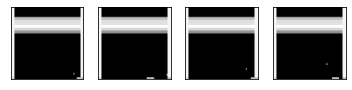

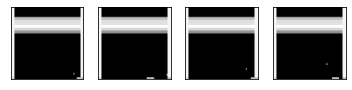

tensor([[0.4161, 0.1235, 0.0383, 0.4221]], grad_fn=<SoftmaxBackward>)
3
0.0


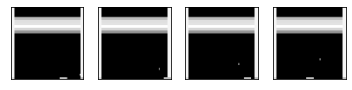

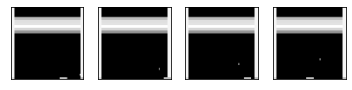

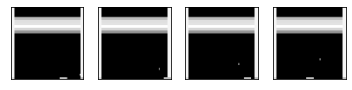

tensor([[0.4385, 0.1035, 0.0381, 0.4199]], grad_fn=<SoftmaxBackward>)
3
0.0


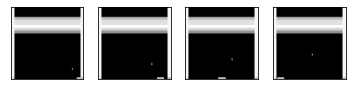

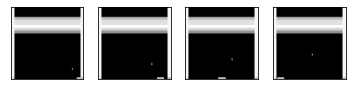

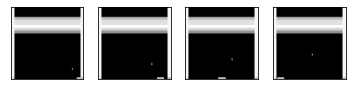

tensor([[0.4496, 0.1114, 0.0381, 0.4009]], grad_fn=<SoftmaxBackward>)
3
0.0


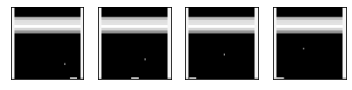

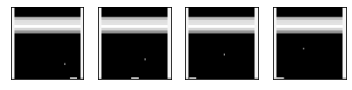

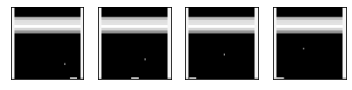

tensor([[0.4560, 0.1067, 0.0394, 0.3980]], grad_fn=<SoftmaxBackward>)
0
0.0


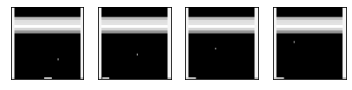

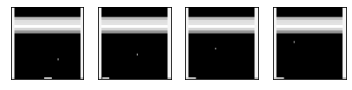

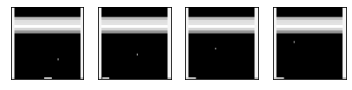

tensor([[0.4641, 0.1033, 0.0384, 0.3942]], grad_fn=<SoftmaxBackward>)
0
0.0


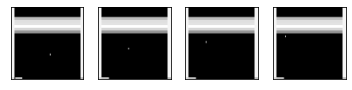

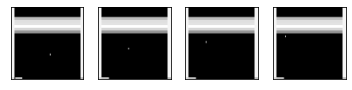

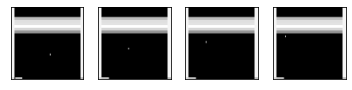

tensor([[0.4401, 0.1041, 0.0375, 0.4184]], grad_fn=<SoftmaxBackward>)
2
1.0


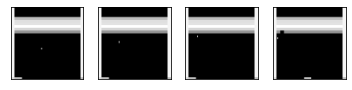

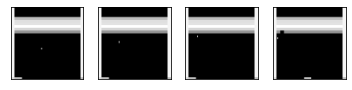

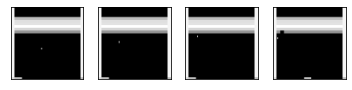

tensor([[0.4620, 0.1040, 0.0361, 0.3980]], grad_fn=<SoftmaxBackward>)
3
0.0


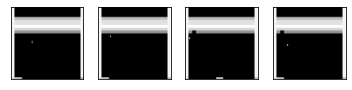

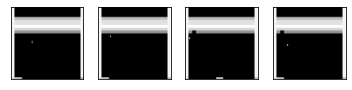

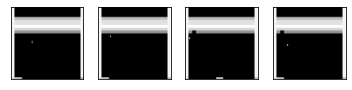

tensor([[0.4449, 0.1118, 0.0405, 0.4028]], grad_fn=<SoftmaxBackward>)
0
0.0


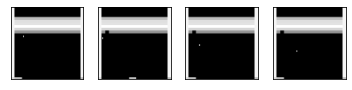

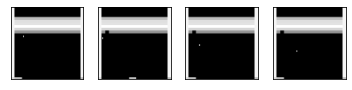

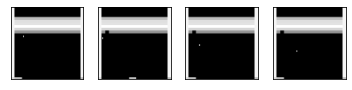

tensor([[0.4436, 0.1101, 0.0400, 0.4063]], grad_fn=<SoftmaxBackward>)
3
0.0


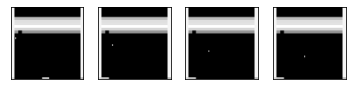

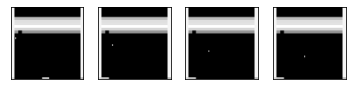

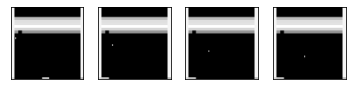

tensor([[0.4667, 0.1067, 0.0411, 0.3856]], grad_fn=<SoftmaxBackward>)
0
0.0


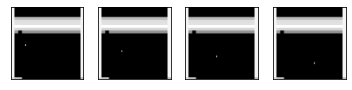

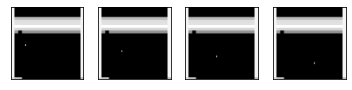

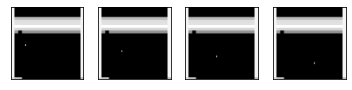

tensor([[0.4456, 0.1099, 0.0389, 0.4056]], grad_fn=<SoftmaxBackward>)
3
0.0


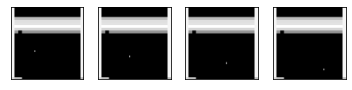

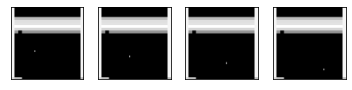

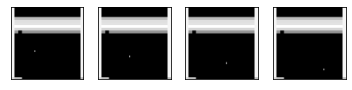

tensor([[0.4581, 0.1059, 0.0415, 0.3946]], grad_fn=<SoftmaxBackward>)
0
0.0


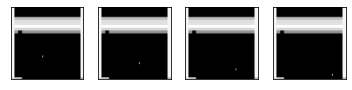

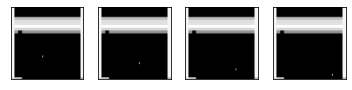

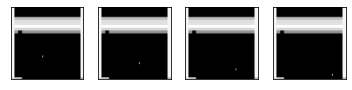

tensor([[0.4536, 0.1058, 0.0393, 0.4013]], grad_fn=<SoftmaxBackward>)
2
0.0


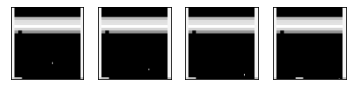

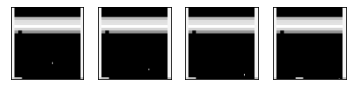

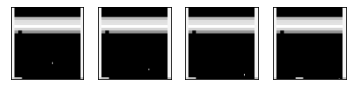

tensor([[0.4519, 0.1094, 0.0396, 0.3992]], grad_fn=<SoftmaxBackward>)
0
0.0


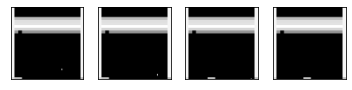

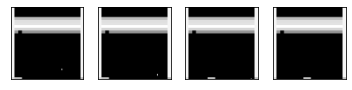

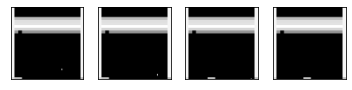

tensor([[0.4562, 0.1119, 0.0388, 0.3930]], grad_fn=<SoftmaxBackward>)
0
0.0


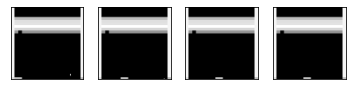

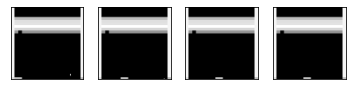

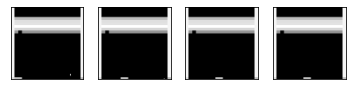

tensor([[0.4369, 0.1090, 0.0396, 0.4145]], grad_fn=<SoftmaxBackward>)
1
0.0


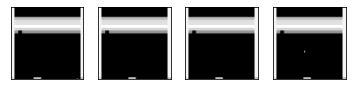

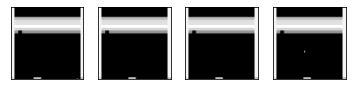

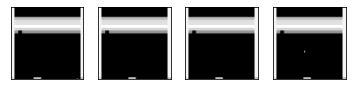

tensor([[0.4467, 0.1052, 0.0380, 0.4101]], grad_fn=<SoftmaxBackward>)
0
0.0


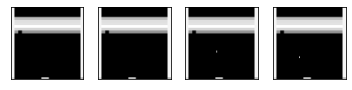

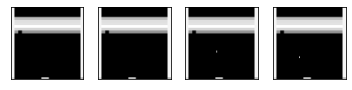

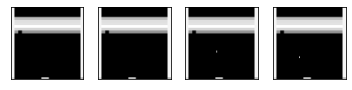

tensor([[0.4852, 0.1004, 0.0391, 0.3753]], grad_fn=<SoftmaxBackward>)
0
0.0


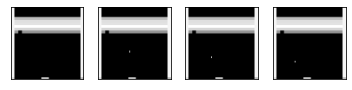

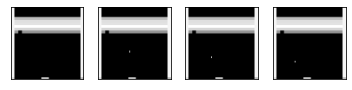

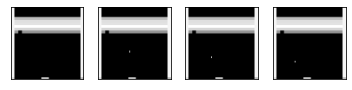

tensor([[0.4958, 0.0969, 0.0372, 0.3701]], grad_fn=<SoftmaxBackward>)
0
0.0


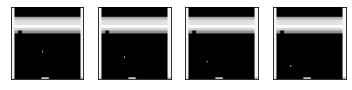

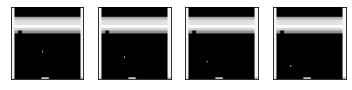

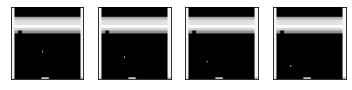

tensor([[0.5006, 0.0932, 0.0353, 0.3709]], grad_fn=<SoftmaxBackward>)
3
0.0


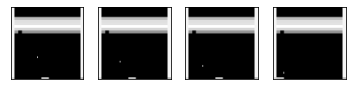

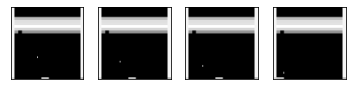

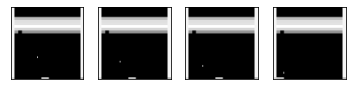

tensor([[0.4777, 0.1067, 0.0386, 0.3770]], grad_fn=<SoftmaxBackward>)
3
0.0


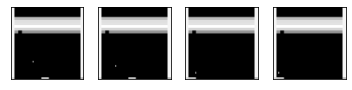

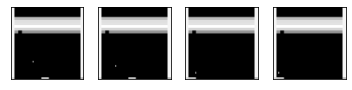

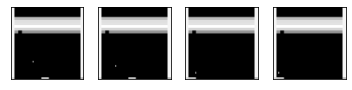

tensor([[0.4825, 0.1037, 0.0393, 0.3746]], grad_fn=<SoftmaxBackward>)
0
0.0


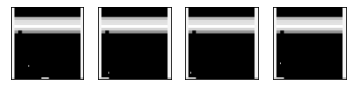

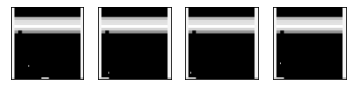

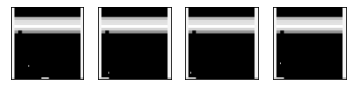

tensor([[0.4597, 0.1099, 0.0390, 0.3915]], grad_fn=<SoftmaxBackward>)
0
0.0


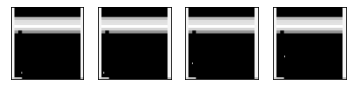

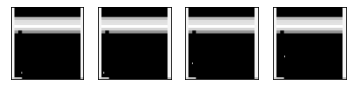

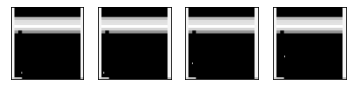

tensor([[0.4473, 0.1127, 0.0393, 0.4007]], grad_fn=<SoftmaxBackward>)
0
0.0


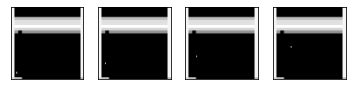

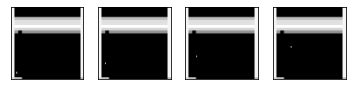

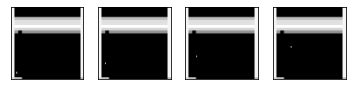

tensor([[0.4380, 0.1113, 0.0373, 0.4134]], grad_fn=<SoftmaxBackward>)
1
0.0


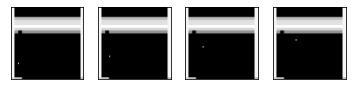

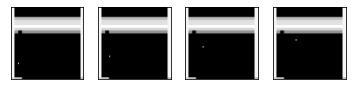

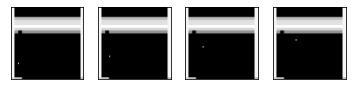

tensor([[0.4408, 0.1161, 0.0400, 0.4031]], grad_fn=<SoftmaxBackward>)
0
1.0


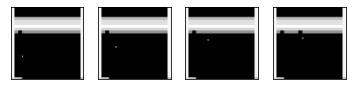

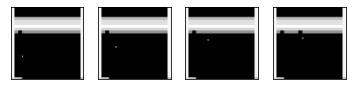

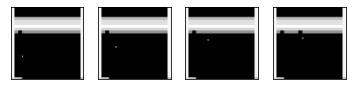

tensor([[0.4456, 0.1147, 0.0385, 0.4012]], grad_fn=<SoftmaxBackward>)
3
0.0


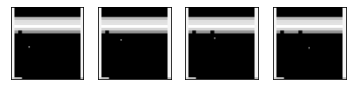

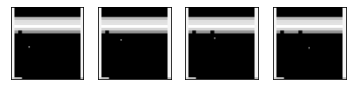

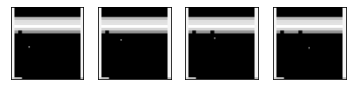

tensor([[0.4629, 0.1075, 0.0397, 0.3899]], grad_fn=<SoftmaxBackward>)
0
0.0


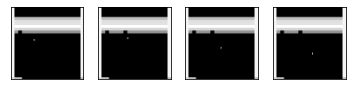

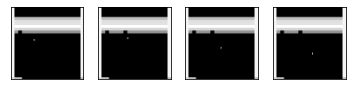

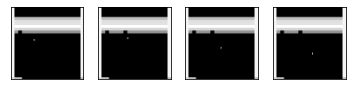

tensor([[0.4428, 0.1047, 0.0405, 0.4120]], grad_fn=<SoftmaxBackward>)
0
0.0


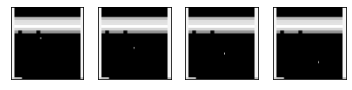

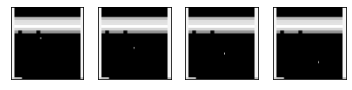

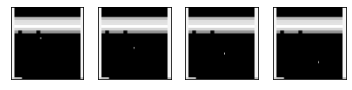

tensor([[0.4613, 0.1037, 0.0418, 0.3932]], grad_fn=<SoftmaxBackward>)
3
0.0


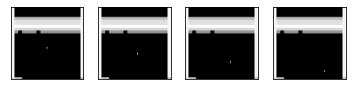

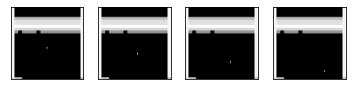

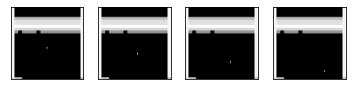

tensor([[0.4702, 0.0991, 0.0411, 0.3896]], grad_fn=<SoftmaxBackward>)
1
0.0


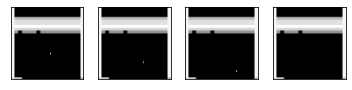

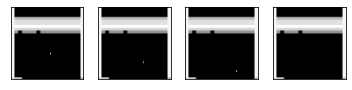

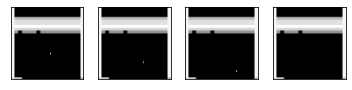

tensor([[0.4611, 0.1027, 0.0398, 0.3964]], grad_fn=<SoftmaxBackward>)
0
0.0


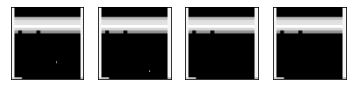

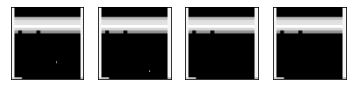

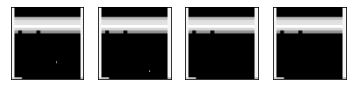

tensor([[0.4584, 0.1083, 0.0391, 0.3942]], grad_fn=<SoftmaxBackward>)
0
0.0


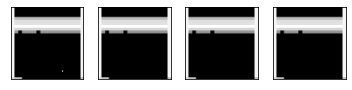

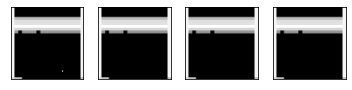

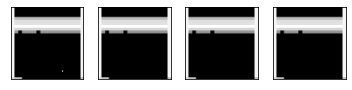

tensor([[0.4494, 0.1097, 0.0405, 0.4004]], grad_fn=<SoftmaxBackward>)
0
0.0


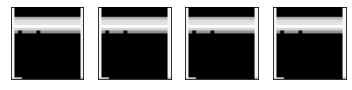

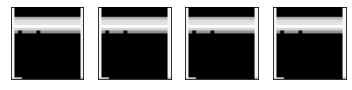

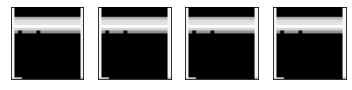

tensor([[0.4472, 0.1104, 0.0407, 0.4018]], grad_fn=<SoftmaxBackward>)
3
0.0


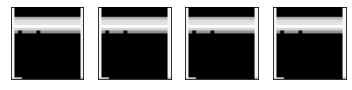

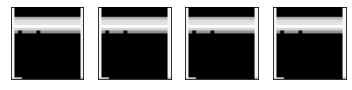

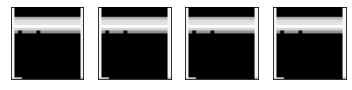

tensor([[0.4472, 0.1104, 0.0407, 0.4018]], grad_fn=<SoftmaxBackward>)
0
0.0


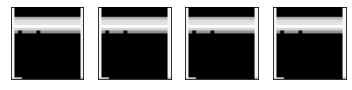

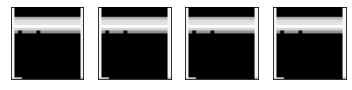

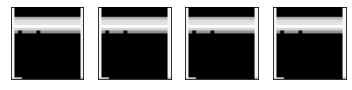

tensor([[0.4472, 0.1104, 0.0407, 0.4018]], grad_fn=<SoftmaxBackward>)
0
0.0


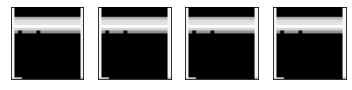

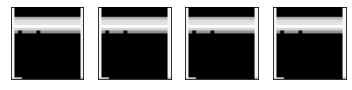

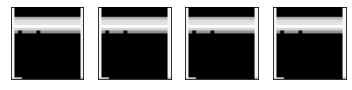

tensor([[0.4472, 0.1104, 0.0407, 0.4018]], grad_fn=<SoftmaxBackward>)
3
0.0


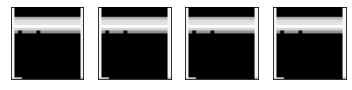

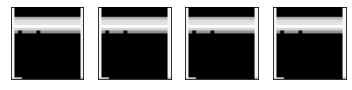

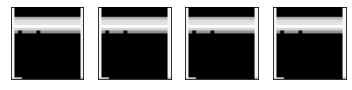

tensor([[0.4472, 0.1104, 0.0407, 0.4018]], grad_fn=<SoftmaxBackward>)
0
0.0


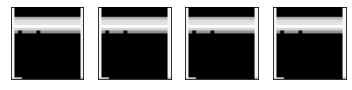

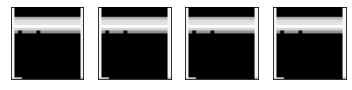

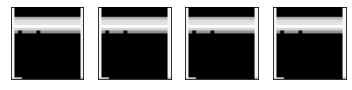

tensor([[0.4472, 0.1104, 0.0407, 0.4018]], grad_fn=<SoftmaxBackward>)
1
0.0


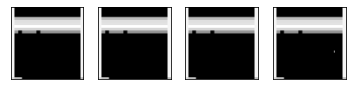

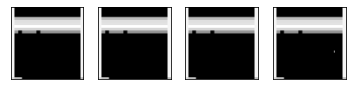

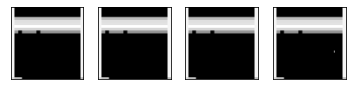

tensor([[0.4495, 0.1099, 0.0403, 0.4003]], grad_fn=<SoftmaxBackward>)
0
0.0


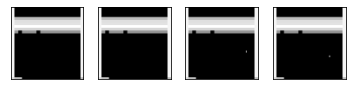

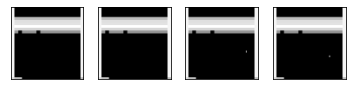

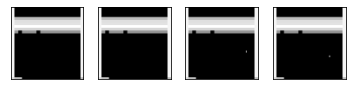

tensor([[0.4592, 0.1091, 0.0412, 0.3906]], grad_fn=<SoftmaxBackward>)
3
0.0


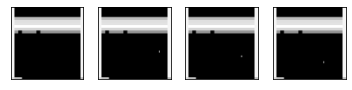

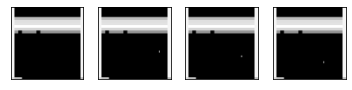

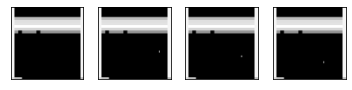

tensor([[0.4544, 0.1058, 0.0407, 0.3991]], grad_fn=<SoftmaxBackward>)
0
0.0


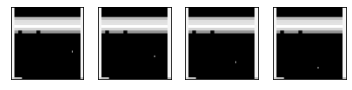

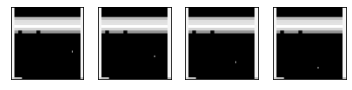

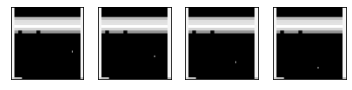

tensor([[0.4579, 0.1045, 0.0400, 0.3977]], grad_fn=<SoftmaxBackward>)
0
0.0


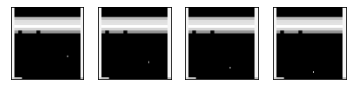

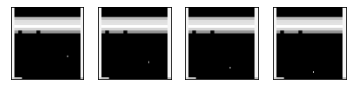

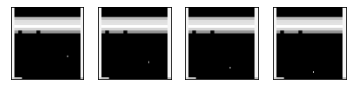

tensor([[0.4575, 0.1066, 0.0406, 0.3952]], grad_fn=<SoftmaxBackward>)
3
0.0


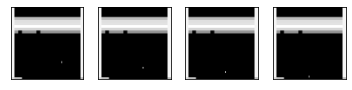

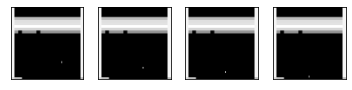

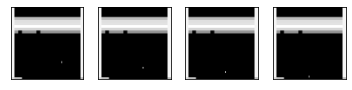

tensor([[0.4733, 0.1053, 0.0401, 0.3813]], grad_fn=<SoftmaxBackward>)
1
0.0


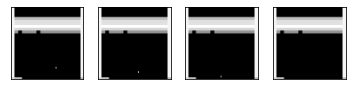

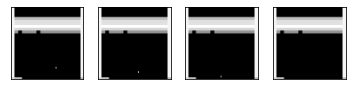

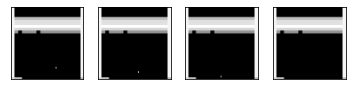

tensor([[0.4680, 0.1089, 0.0408, 0.3823]], grad_fn=<SoftmaxBackward>)
2
0.0


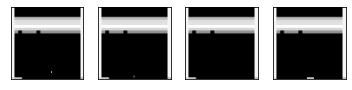

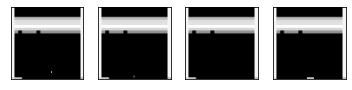

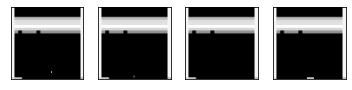

tensor([[0.4632, 0.1086, 0.0412, 0.3869]], grad_fn=<SoftmaxBackward>)
0
0.0


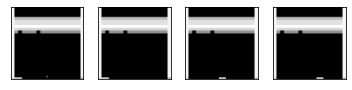

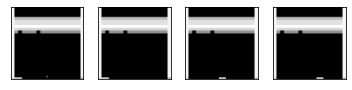

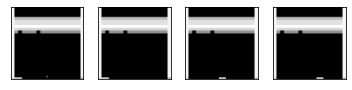

tensor([[0.4498, 0.1125, 0.0441, 0.3937]], grad_fn=<SoftmaxBackward>)
3
0.0


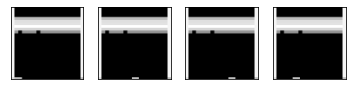

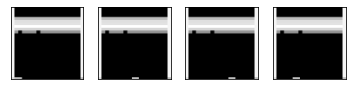

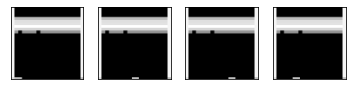

tensor([[0.4706, 0.1033, 0.0417, 0.3844]], grad_fn=<SoftmaxBackward>)
3
0.0


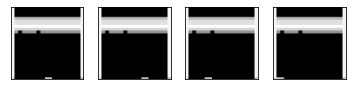

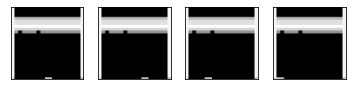

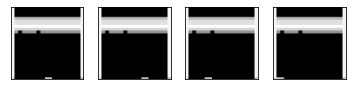

tensor([[0.4719, 0.1056, 0.0414, 0.3811]], grad_fn=<SoftmaxBackward>)
1
0.0


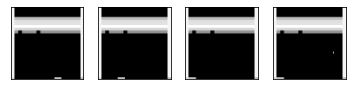

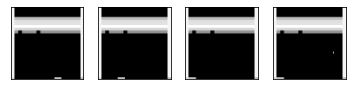

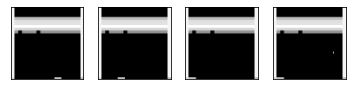

tensor([[0.4523, 0.1090, 0.0419, 0.3968]], grad_fn=<SoftmaxBackward>)
3
0.0


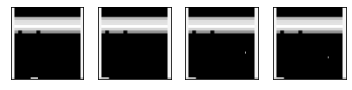

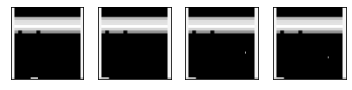

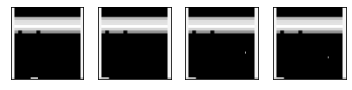

tensor([[0.4556, 0.1054, 0.0400, 0.3991]], grad_fn=<SoftmaxBackward>)
2
0.0


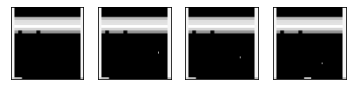

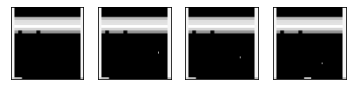

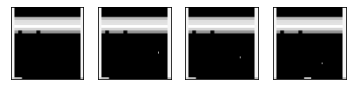

tensor([[0.4658, 0.1032, 0.0386, 0.3924]], grad_fn=<SoftmaxBackward>)
0
0.0


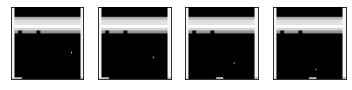

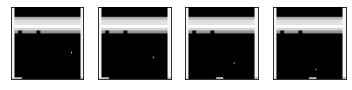

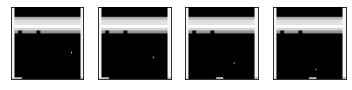

tensor([[0.4691, 0.1038, 0.0417, 0.3854]], grad_fn=<SoftmaxBackward>)
3
0.0


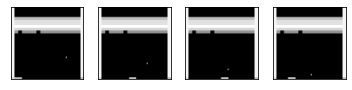

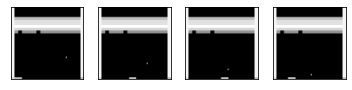

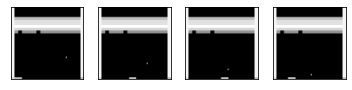

tensor([[0.4777, 0.0981, 0.0386, 0.3856]], grad_fn=<SoftmaxBackward>)
3
0.0


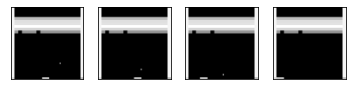

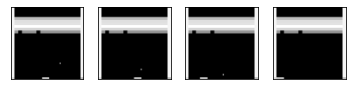

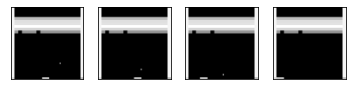

tensor([[0.4881, 0.1018, 0.0411, 0.3690]], grad_fn=<SoftmaxBackward>)
1
0.0


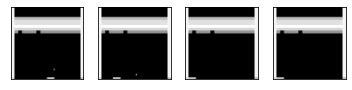

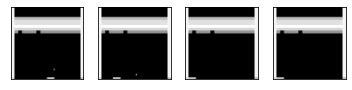

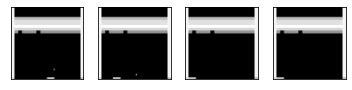

tensor([[0.4597, 0.1065, 0.0421, 0.3917]], grad_fn=<SoftmaxBackward>)
3
0.0


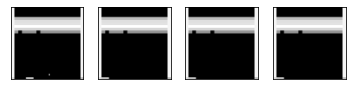

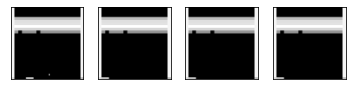

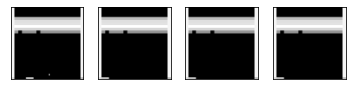

tensor([[0.4553, 0.1081, 0.0402, 0.3964]], grad_fn=<SoftmaxBackward>)
3
0.0


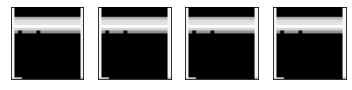

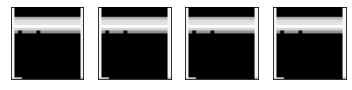

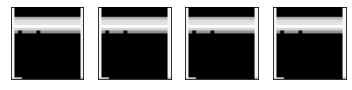

tensor([[0.4472, 0.1104, 0.0407, 0.4018]], grad_fn=<SoftmaxBackward>)
3
0.0


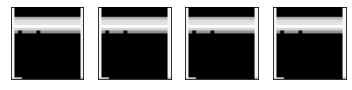

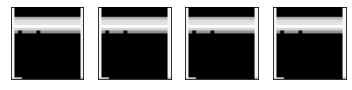

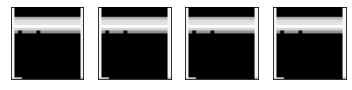

tensor([[0.4472, 0.1104, 0.0407, 0.4018]], grad_fn=<SoftmaxBackward>)
0
0.0


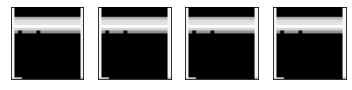

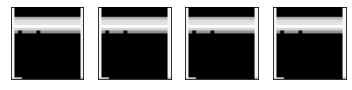

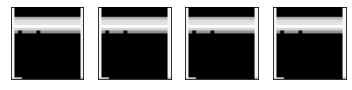

tensor([[0.4472, 0.1104, 0.0407, 0.4018]], grad_fn=<SoftmaxBackward>)
0
0.0


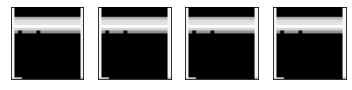

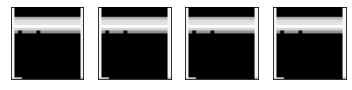

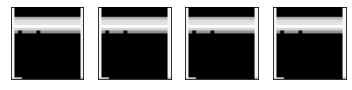

tensor([[0.4472, 0.1104, 0.0407, 0.4018]], grad_fn=<SoftmaxBackward>)
0
0.0


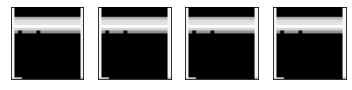

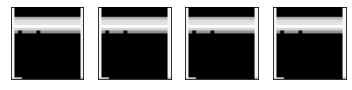

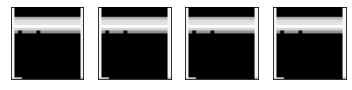

tensor([[0.4472, 0.1104, 0.0407, 0.4018]], grad_fn=<SoftmaxBackward>)
3
0.0


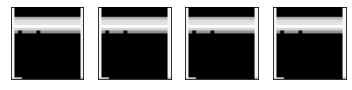

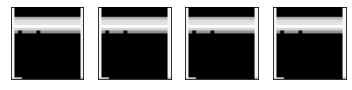

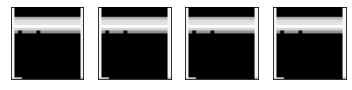

tensor([[0.4472, 0.1104, 0.0407, 0.4018]], grad_fn=<SoftmaxBackward>)
0
0.0


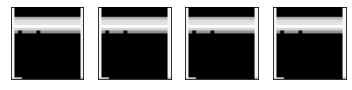

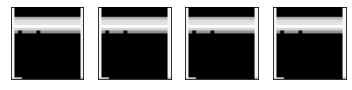

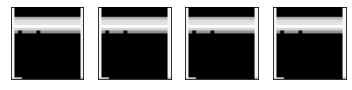

tensor([[0.4472, 0.1104, 0.0407, 0.4018]], grad_fn=<SoftmaxBackward>)
0
0.0


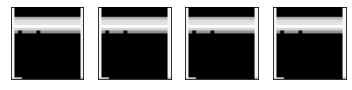

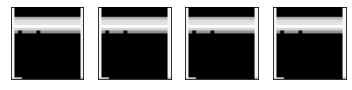

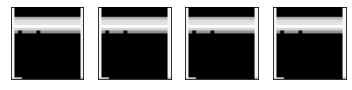

tensor([[0.4472, 0.1104, 0.0407, 0.4018]], grad_fn=<SoftmaxBackward>)
1
0.0


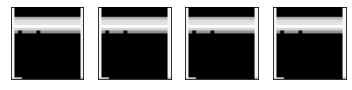

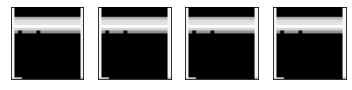

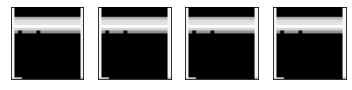

tensor([[0.4472, 0.1104, 0.0407, 0.4018]], grad_fn=<SoftmaxBackward>)
0
0.0


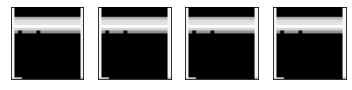

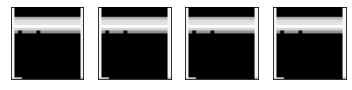

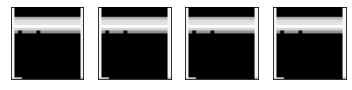

tensor([[0.4472, 0.1104, 0.0407, 0.4018]], grad_fn=<SoftmaxBackward>)
0
0.0


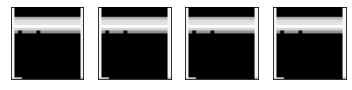

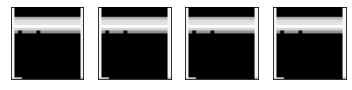

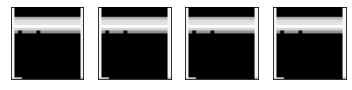

tensor([[0.4472, 0.1104, 0.0407, 0.4018]], grad_fn=<SoftmaxBackward>)
3
0.0


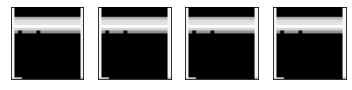

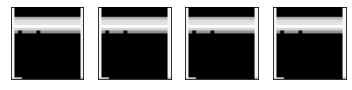

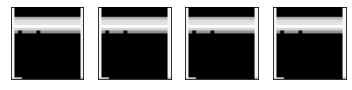

tensor([[0.4472, 0.1104, 0.0407, 0.4018]], grad_fn=<SoftmaxBackward>)
0
0.0


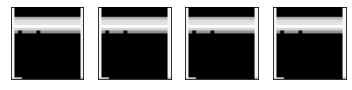

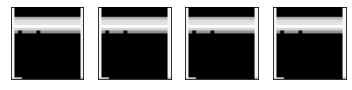

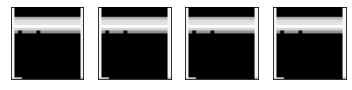

tensor([[0.4472, 0.1104, 0.0407, 0.4018]], grad_fn=<SoftmaxBackward>)
0
0.0


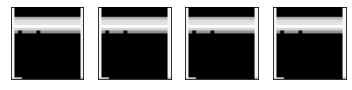

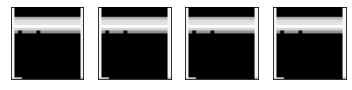

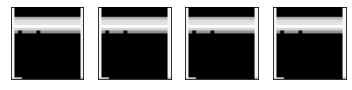

tensor([[0.4472, 0.1104, 0.0407, 0.4018]], grad_fn=<SoftmaxBackward>)
0
0.0


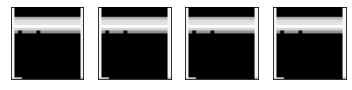

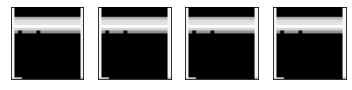

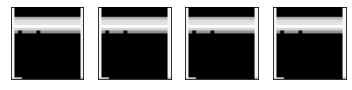

tensor([[0.4472, 0.1104, 0.0407, 0.4018]], grad_fn=<SoftmaxBackward>)
0
0.0


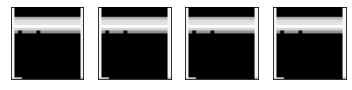

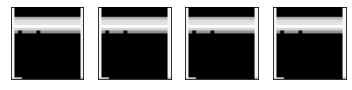

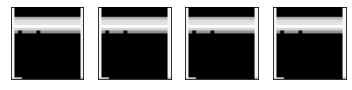

tensor([[0.4472, 0.1104, 0.0407, 0.4018]], grad_fn=<SoftmaxBackward>)
0
0.0


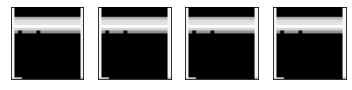

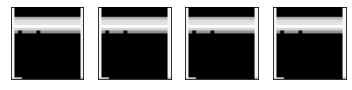

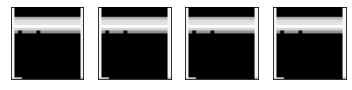

tensor([[0.4472, 0.1104, 0.0407, 0.4018]], grad_fn=<SoftmaxBackward>)
0
0.0


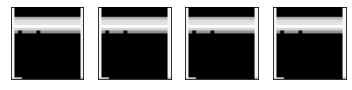

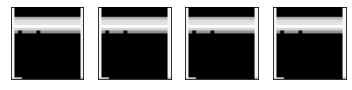

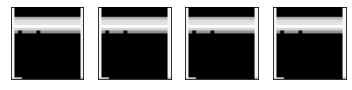

tensor([[0.4472, 0.1104, 0.0407, 0.4018]], grad_fn=<SoftmaxBackward>)
2
0.0


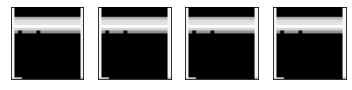

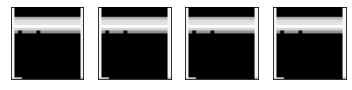

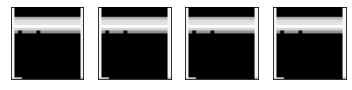

tensor([[0.4472, 0.1104, 0.0407, 0.4018]], grad_fn=<SoftmaxBackward>)
0
0.0


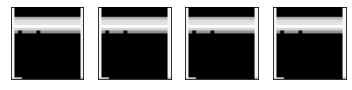

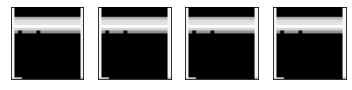

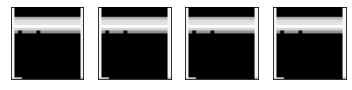

tensor([[0.4472, 0.1104, 0.0407, 0.4018]], grad_fn=<SoftmaxBackward>)
3
0.0


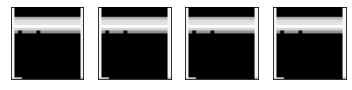

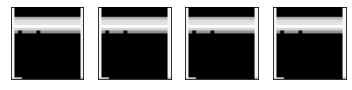

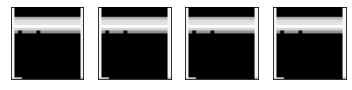

tensor([[0.4472, 0.1104, 0.0407, 0.4018]], grad_fn=<SoftmaxBackward>)
3
0.0


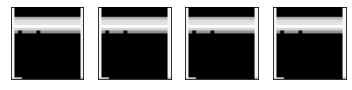

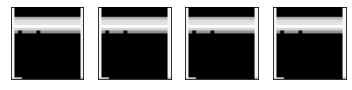

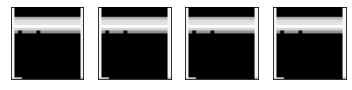

tensor([[0.4472, 0.1104, 0.0407, 0.4018]], grad_fn=<SoftmaxBackward>)
3
0.0


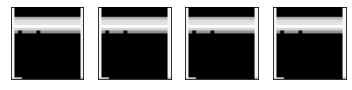

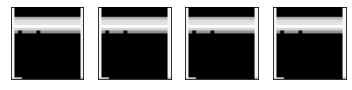

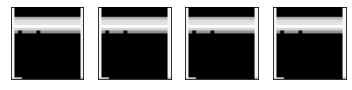

tensor([[0.4472, 0.1104, 0.0407, 0.4018]], grad_fn=<SoftmaxBackward>)
0
0.0


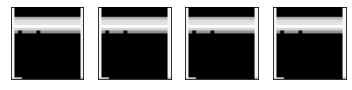

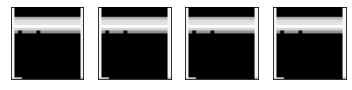

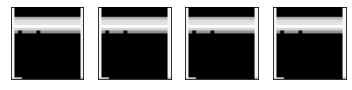

tensor([[0.4472, 0.1104, 0.0407, 0.4018]], grad_fn=<SoftmaxBackward>)
0
0.0


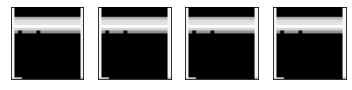

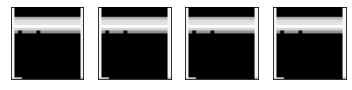

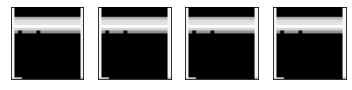

tensor([[0.4472, 0.1104, 0.0407, 0.4018]], grad_fn=<SoftmaxBackward>)
3
0.0


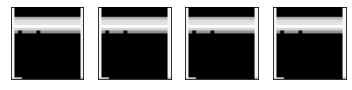

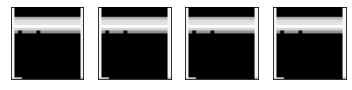

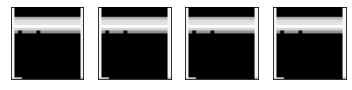

tensor([[0.4472, 0.1104, 0.0407, 0.4018]], grad_fn=<SoftmaxBackward>)
0
0.0


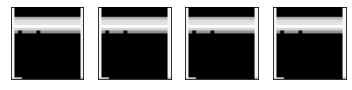

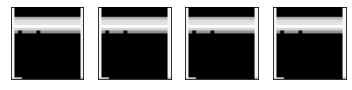

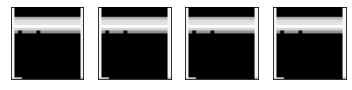

tensor([[0.4472, 0.1104, 0.0407, 0.4018]], grad_fn=<SoftmaxBackward>)
3
0.0


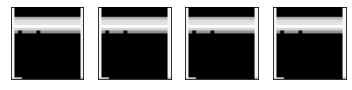

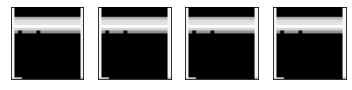

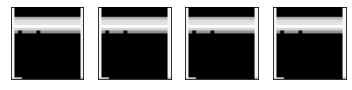

tensor([[0.4472, 0.1104, 0.0407, 0.4018]], grad_fn=<SoftmaxBackward>)
0
0.0


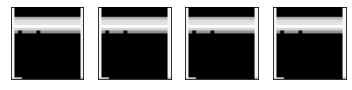

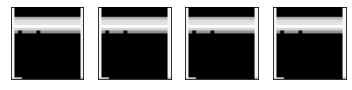

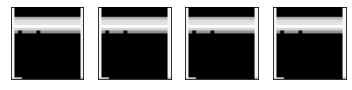

tensor([[0.4472, 0.1104, 0.0407, 0.4018]], grad_fn=<SoftmaxBackward>)
0
0.0


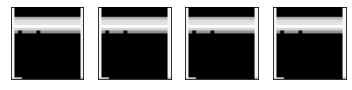

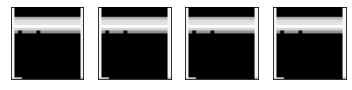

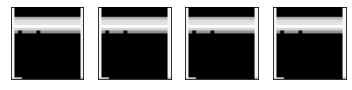

tensor([[0.4472, 0.1104, 0.0407, 0.4018]], grad_fn=<SoftmaxBackward>)
1
0.0


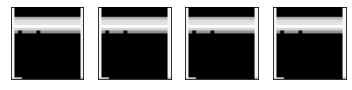

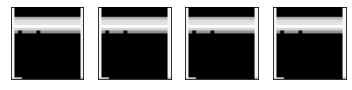

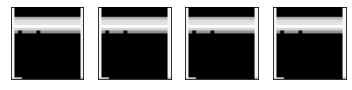

tensor([[0.4472, 0.1104, 0.0407, 0.4018]], grad_fn=<SoftmaxBackward>)
0
0.0


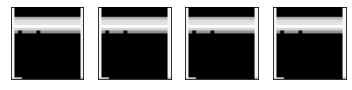

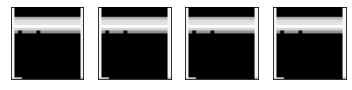

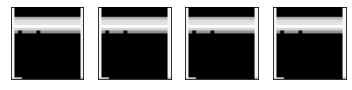

tensor([[0.4472, 0.1104, 0.0407, 0.4018]], grad_fn=<SoftmaxBackward>)
3
0.0


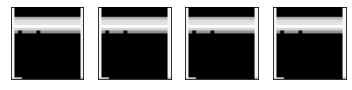

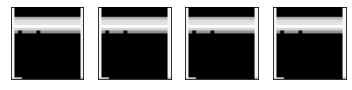

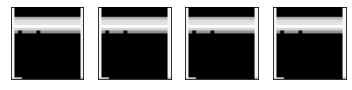

tensor([[0.4472, 0.1104, 0.0407, 0.4018]], grad_fn=<SoftmaxBackward>)
0
0.0


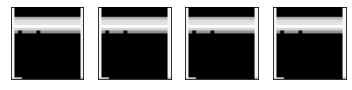

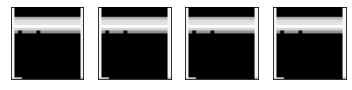

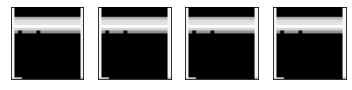

tensor([[0.4472, 0.1104, 0.0407, 0.4018]], grad_fn=<SoftmaxBackward>)
0
0.0


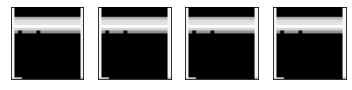

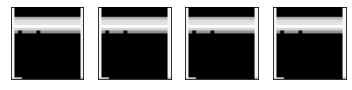

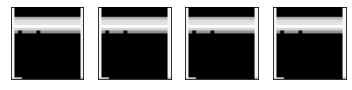

tensor([[0.4472, 0.1104, 0.0407, 0.4018]], grad_fn=<SoftmaxBackward>)
3
0.0


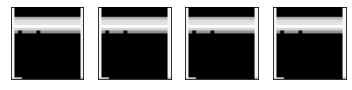

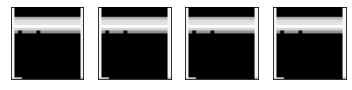

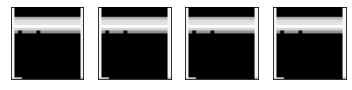

tensor([[0.4472, 0.1104, 0.0407, 0.4018]], grad_fn=<SoftmaxBackward>)
3
0.0


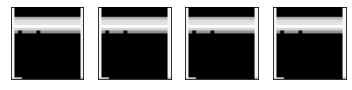

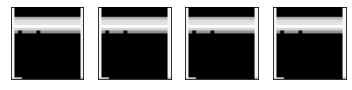

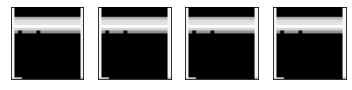

tensor([[0.4472, 0.1104, 0.0407, 0.4018]], grad_fn=<SoftmaxBackward>)
0
0.0


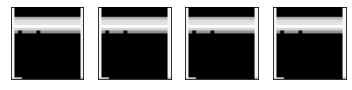

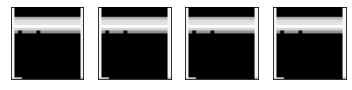

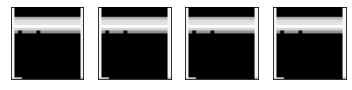

tensor([[0.4472, 0.1104, 0.0407, 0.4018]], grad_fn=<SoftmaxBackward>)
0
0.0


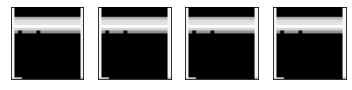

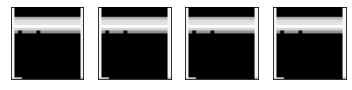

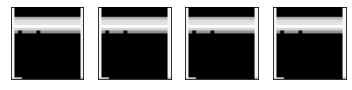

tensor([[0.4472, 0.1104, 0.0407, 0.4018]], grad_fn=<SoftmaxBackward>)
0
0.0


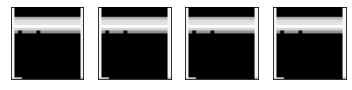

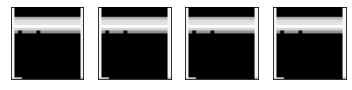

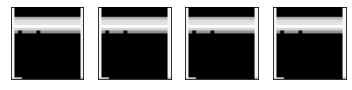

tensor([[0.4472, 0.1104, 0.0407, 0.4018]], grad_fn=<SoftmaxBackward>)
2
0.0


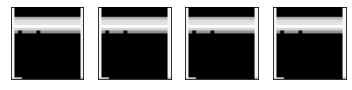

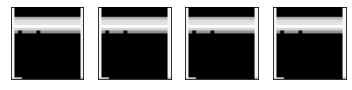

tensor([[3.2228e-04, 6.9184e-02, 4.2042e-02, 8.8845e-01]],
       grad_fn=<SoftmaxBackward>)
tensor(1., grad_fn=<SumBackward0>)


In [123]:
model = PPO()

obs = preprocess(env.reset())
show_image(obs)
plt.show()

state = np.stack((obs, obs, obs, obs), axis=0)

for _ in range(128):
    show_state(state)
    plt.show()  
    
    prob = model.pi(torch.FloatTensor(state).unsqueeze(0))
    print(prob)

    m = Categorical(prob)
    a = m.sample().item()
    print(a)

    reward = 0
    for _ in range(4):
        next_obs, r, done, info = env.step(a)
        reward += r

        if done:
            break
    print(reward)

    next_state = np.roll(state, shift=-1, axis=0)
    next_state[-1] = preprocess(next_obs) 
    show_state(next_state)
    plt.show()

    model.put_data((state, a, reward, next_state, prob.cpu().detach().numpy()[0][a], done))

    state = next_state
    show_state(state)
    plt.show()

model.train_net()

prob = model.pi(torch.from_numpy(state).float().unsqueeze(0))
print(prob)
print(torch.sum(prob))